In [1]:
import requests
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session

import matplotlib.pyplot as plt

import io
from PIL import Image
import numpy as np

In [2]:
# Set credentials
client_id = ""
client_secret = ""

In [3]:
# Set up credentials for use with batch
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)

# Fetch a token
token = oauth.fetch_token(token_url='https://services.sentinel-hub.com/oauth/token',
                          client_id=client_id, client_secret=client_secret)


In [4]:
# Set bounding box coordinates for the area of interest
bbox = (12.44693, 41.870072, 12.541001, 41.917096)  # Rome

In [5]:
# 1. Bounds 
bounds = {"properties":{"crs":"http://www.opengis.net/def/crs/OGC/1.3/CRS84"}, "bbox": bbox}

# 2. Data
# Following Filgueiras et al. (2019), the Sentinel-1 orthorectified sigma_0 bands are returned.
# We also use Atmospherically corrected Sentinel-2 (L2A) data

data = [{"type": "S2L2A",
         "dataFilter": {
             "timeRange": {
                 "from": "2020-09-29T00:00:00Z",
                 "to": "2020-10-29T23:59:59Z"}
         }
        }
      ]
# Set the options to the input
input_options = {"bounds": bounds, "data": data,}

In [6]:
output_options = {"width": 640, "height": 640, "responses": [{"format": {"type": "image/jpeg",
                                                                         "quality": 90}}]}


In [7]:
# 1. Evalscript returning the True Color Visualisation of S2 data
tc_evalscript = """
//VERSION=3

function setup() {
  return {
    input: ["B02", "B03", "B04"],
    output: { bands: 3 }
  };
}

function evaluatePixel(sample) {
  return [2.5 * sample.B04, 2.5 * sample.B03, 2.5 * sample.B02];
}
"""

In [8]:
# Here we call the first evalscript for a True Color visualisation of Sentinel-2. 
response_tc = oauth.post('https://services.sentinel-hub.com/api/v1/process',
  json={"input": input_options,
        "evalscript": tc_evalscript,
        "output": output_options,
})
print("Request status: %s, %s" % (response_tc.status_code, response_tc.reason))

Request status: 200, OK


In [9]:
# Decode binary response to numpy array
image = np.array(Image.open(io.BytesIO(response_tc.content))) 

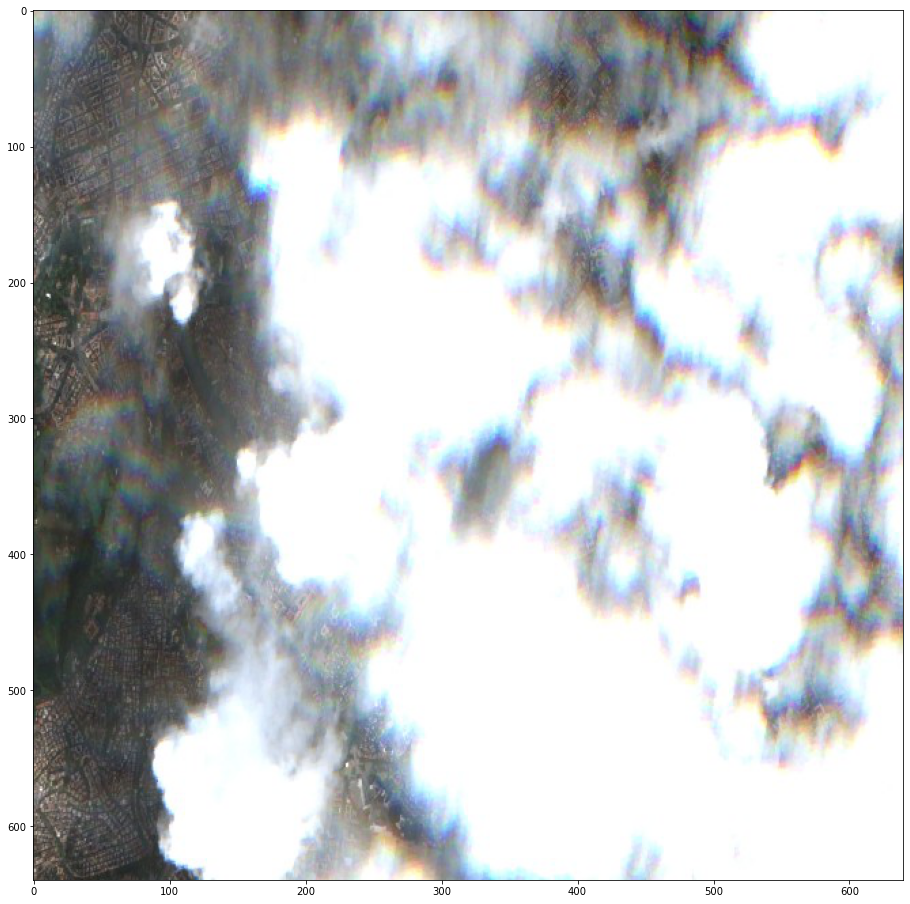

In [10]:
# Plot
plt.figure(figsize=(16,16))
plt.imshow(image)